<a href="https://colab.research.google.com/github/mike-scally/ET5003/blob/main/ET5003_Etivity2_MikeScally_9312951.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [84]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [85]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "9312951" #@param {type:"string"}
Student_full_name = "Mike Scally" #@param {type:"string"}
#@markdown ---

In [86]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Draft" #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

###Problem Description

In this Etivity, we will build a supervised machine learning model to predict house prices. We will use data from the house prices dataset to train our model. We will use a linear regression approach in order to predict the relationship between our input variables for house properties, and our target variable the predicted hourse price. We will compare the predicted house prices from our model against the true values from the data, to evaluate the results. These differences between observed and true values are known as residuals (Bock, 2021).

We initially load the data and perform some EDA to understand the composition of the data, the makeup of the different house properties, look for missing data etc. Once we have cleaned up the data, we build a baseline Bayesian multinomial regression model that treats all the data as one and builds a model to predict house prices based on this one model.

We then take a Piecewise regression approach to solving the same problem. Piecewise regression, also known as Segmented Regression is an approach where we break the data into multiple segments, and then apply linear regression seperately on each of the segments. Piecewise regression is useful when data once clustered into individual groups, the independent variables in each of the groups exhibits different relationships between each other. The boundaries between different segments in piecewise regression are called breakpoints (Segmented regression - Wikipedia, 2021)

Piecewise regression is a variation of linear regression and can be used when a single line is not sufficient to model the entire dataset. In such cases, the data is split itto multiple different clusters, and an individual line/model can be fit to each cluster to better represent the data (Kappel, 2017).

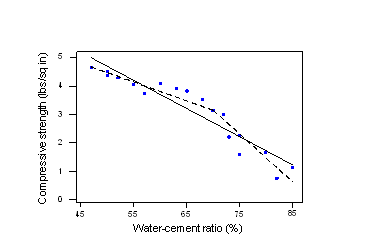

The above diagram shows an example of where piecewise regression can imporve on the prediction of the model. The solid line represents an estimate of the regression line when all the data is treated as one. However, if we break the data into multiple segments, and use piecewise regression to train the model on each segment seperately, we end up with the 2 dotted lines, which shows a better fit for the data (Penn State, 2021)

###Dataset



## Imports

In [87]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import cluster

In [89]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [90]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

### Load the Dataset

In [91]:
#Load the dataset
from google.colab import drive
drive.mount('/content/drive')

# Path, copy the path from your Drive
Path = '/content/drive/My Drive/Colab Notebooks/data/house-prices/'

training_file = Path + 'house_train.csv'
testing_file = Path + 'house_test.csv'
cost_file = Path + 'true_price.csv'

# Load training data
dftrain = pd.read_csv(training_file)

# test data
dftest = pd.read_csv(testing_file)

# test prices
dfcost = pd.read_csv(cost_file)

print("Train Data Shape:", dftrain.shape)
print("Test Data Shape:", dftest.shape)
print("True Data Shape:", dfcost.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Data Shape: (2982, 17)
Test Data Shape: (500, 16)
True Data Shape: (500, 2)


### Train dataset

In [92]:
# Show first few rows
dftrain.head(5)

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [93]:
#Show some statistics
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


### Test dataset

In [94]:
# show first data frame rows 
dftest.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


In [95]:
# Generate descriptive statistics
dftest.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,surface
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,0.0,500.000000
mean,1.231695e+07,1.994000,2.930000,53.356034,-6.247842,NaN,156.007671
std,1.485832e+05,1.106532,1.191612,0.081905,0.088552,NaN,344.497362
min,1.130615e+07,0.000000,0.000000,53.221348,-6.496987,NaN,33.500000
25%,1.228617e+07,1.000000,2.000000,53.297373,-6.296404,NaN,72.375000
50%,1.237964e+07,2.000000,3.000000,53.339547,-6.243572,NaN,98.000000
75%,1.240544e+07,3.000000,4.000000,53.381650,-6.185055,NaN,138.935000
max,1.242809e+07,8.000000,7.000000,53.619775,-6.064874,NaN,5746.536120


### Expected Cost dataset

In [96]:
# Generate descriptive statistics
dfcost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


### Exploratory Data Analysis and Cleansing

### Selecting Most Important Features to use

In [97]:
#Number of units is almost all blank, so I will remove that column, even though we could also encode this
if ('no_of_units') in dftrain:
  dftrain.drop('no_of_units', axis=1, inplace=True)

In [98]:
#Drop the following columns as they are text or ID based
if ('ad_id') in dftrain:
  dftrain.drop('ad_id', axis=1, inplace=True)

if ('description_block') in dftrain:
  dftrain.drop('description_block', axis=1, inplace=True)

#County is always Dublin, so we can remove
if ('county') in dftrain:
  dftrain.drop('county', axis=1, inplace=True)

#environment is always prod, so we can remove
if ('environment') in dftrain:
  dftrain.drop('environment', axis=1, inplace=True)

#facility is text based, so we will exclude
if ('facility') in dftrain:
  dftrain.drop('facility', axis=1, inplace=True)

#features is text based, so we will exclude
if ('features') in dftrain:
  dftrain.drop('features', axis=1, inplace=True)

#ber classification has a lot of missing values, so we will exclude
if ('ber_classification') in dftrain:
  dftrain.drop('ber_classification', axis=1, inplace=True)    


In [99]:
#Some of the surface values are not complete, I will substitute blank ones for a mean value

dftrain['surface'].fillna(dftrain['surface'].mean(), inplace=True)


In [100]:
#Remove bathrooms and beds that are blank, and also blank prices as we cannot train on a predicted blank value
dftrain = dftrain.dropna(subset=['bathrooms'])
dftrain = dftrain.dropna(subset=['price'])

print(dftrain.isna().sum())
print(dftrain.shape)
dftrain.head()

area                 0
bathrooms            0
beds                 0
latitude             0
longitude            0
price                0
property_category    0
property_type        0
surface              0
dtype: int64
(2892, 9)


,area,bathrooms,beds,latitude,longitude,price,property_category,property_type,surface
15,Clonee,3.0,5.0,53.400454,-6.445730,935000.0,new_development_parent,detached,321.0
26,Clondalkin,4.0,4.0,53.316410,-6.385214,485000.0,new_development_parent,semi-detached,144.0
27,Clonee,3.0,5.0,53.401414,-6.446634,935000.0,new_development_parent,detached,321.0
35,Howth,5.0,5.0,53.375377,-6.056749,1475000.0,new_development_parent,detached,312.0
38,Castleknock,2.0,2.0,53.372130,-6.338466,410000.0,new_development_parent,apartment,83.0


In [101]:
#Count records where bedrooms or bathrooms are zero
print("Number of records with zero beds:", (dftrain['beds'] == 0).sum())
print("Number of records with zero bathrooms:", (dftrain['bathrooms'] == 0).sum())

Number of records with zero beds: 48
Number of records with zero bathrooms: 63


In [102]:
#Remove records where bedrooms or bathrooms are zero
dftrain = dftrain[dftrain['beds'] > 0]
dftrain = dftrain[dftrain['bathrooms'] > 0]

In [103]:
#Count again records where bedrooms or bathrooms are zero
print("Number of records with zero beds:", (dftrain['beds'] == 0).sum())
print("Number of records with zero bathrooms:", (dftrain['bathrooms'] == 0).sum())

Number of records with zero beds: 0
Number of records with zero bathrooms: 0


In [104]:
#A method that can encode any column based on the values that exist in that column
def encode_colummn(df, column):
  unique_values = df[column].unique()
  unique_values.shape
  scale_mapper = {}
  i = 0
  for s in unique_values:
    scale_mapper[s] = i
    i += 1

  df[column] =  df[column].replace(scale_mapper)

#Encoding the following categorical variables, treating each as an ordinal
if dftrain['property_type'].dtypes != np.int64:
  encode_colummn(dftrain, 'property_type')

if dftrain['property_category'].dtypes != np.int64:
  encode_colummn(dftrain, 'property_category')

if dftrain['area'].dtypes != np.int64:
  encode_colummn(dftrain, 'area')


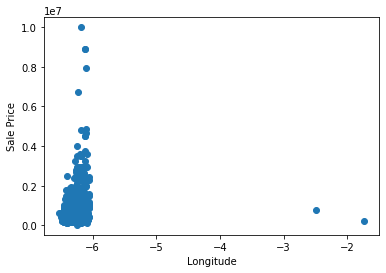

In [105]:
#Lets have a look at longitude values and see if there are outliers
plt.scatter(x=dftrain['longitude'], y=dftrain['price'])
plt.ylabel('Sale Price')
plt.xlabel('Longitude')
plt.show()

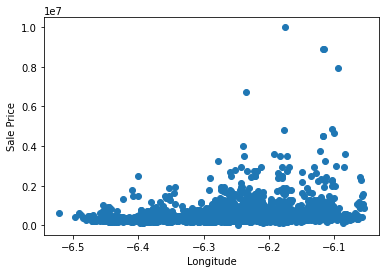

In [106]:
#Remove outliers - where longitude > -4
dftrain = dftrain[dftrain['longitude'] < -4]
#train = train[train['price'] < 4000000]
plt.scatter(x=dftrain['longitude'], y=dftrain['price'])
plt.ylabel('Sale Price')
plt.xlabel('Longitude')
plt.show()

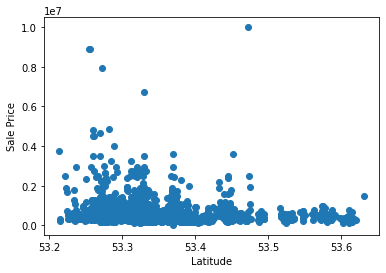

In [107]:
#Lets have a look at the latitude values
plt.scatter(x=dftrain['latitude'], y=dftrain['price'])
plt.ylabel('Sale Price')
plt.xlabel('Latitude')
plt.show()

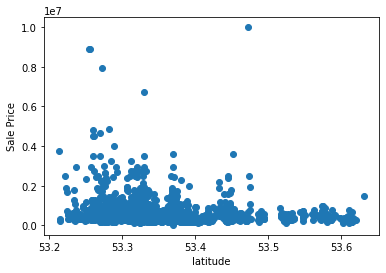

In [108]:
#Remove outliers where latitude < 53
dftrain = dftrain[dftrain['latitude'] > 53]
#train = train[train['price'] < 4000000]
plt.scatter(x=dftrain['latitude'], y=dftrain['price'])
plt.ylabel('Sale Price')
plt.xlabel('latitude')
plt.show()

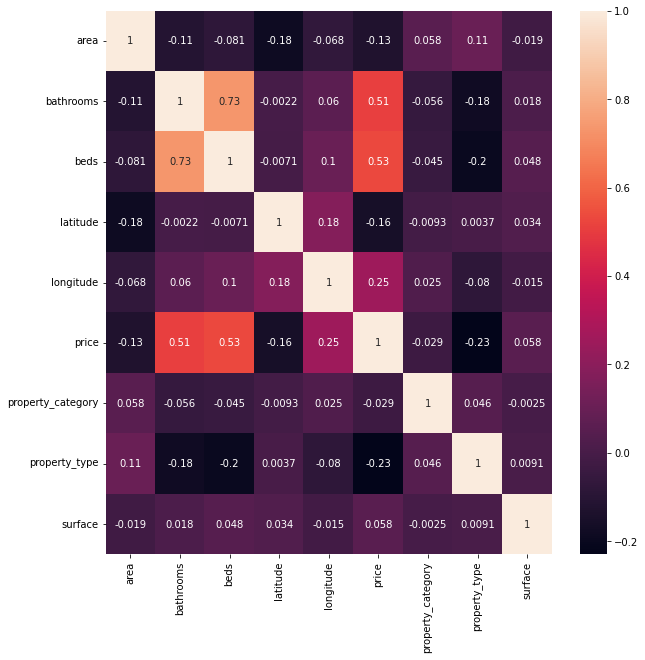

In [109]:
plt.figure(figsize=(10, 10))
sns.heatmap(dftrain.corr(), annot=True);

From the correlation matrix above, bathrooms, beds, and longitude seem to be the best predictors for the price

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#Seperate X, y columns
y = dftrain['price']
X = dftrain.drop('price', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(2260, 8)
(2260,)
(566, 8)
(566,)


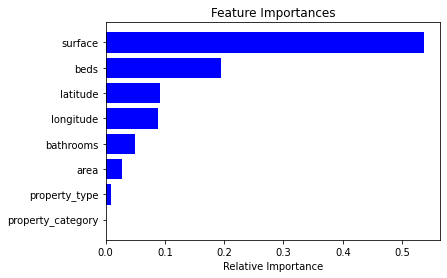

In [111]:
#Use a Random Forest model to determine the most important features to use
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_train, y_train)

features = dftrain.drop('price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [112]:
#Another approach to finding the best features
numeric_features = dftrain.select_dtypes(include=[np.number])
numeric_features.dtypes

corr = numeric_features.corr()
print (corr['price'].sort_values(ascending=False)[:5], '\n')
print (corr['price'].sort_values(ascending=False)[-5:])

price        1.000000
beds         0.530352
bathrooms    0.508730
longitude    0.253504
surface      0.057874
Name: price, dtype: float64 

surface              0.057874
property_category   -0.028892
area                -0.126723
latitude            -0.155263
property_type       -0.229906
Name: price, dtype: float64


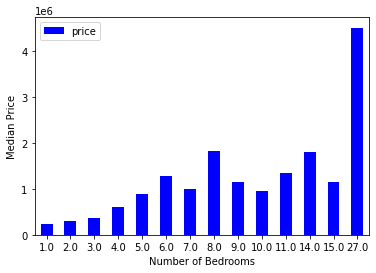

In [113]:
#Relationship between bedrooms and price
bedrooms_pivot = dftrain.pivot_table(index='beds',
                  values='price', aggfunc=np.median)

bedrooms_pivot.plot(kind='bar', color='blue')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Median Price')
plt.xticks(rotation=0)
plt.show()

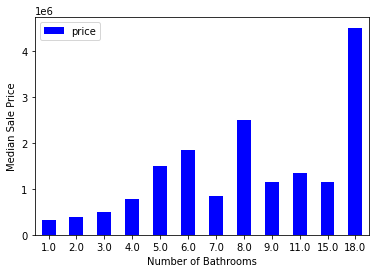

In [114]:
#Relationship between bathrooms and price
bathrooms_pivot = dftrain.pivot_table(index='bathrooms',
                  values='price', aggfunc=np.median)

bathrooms_pivot.plot(kind='bar', color='blue')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

The above shows the most important features in the model. We will use this feature important dataset to select the most important features to use in predicting house prices

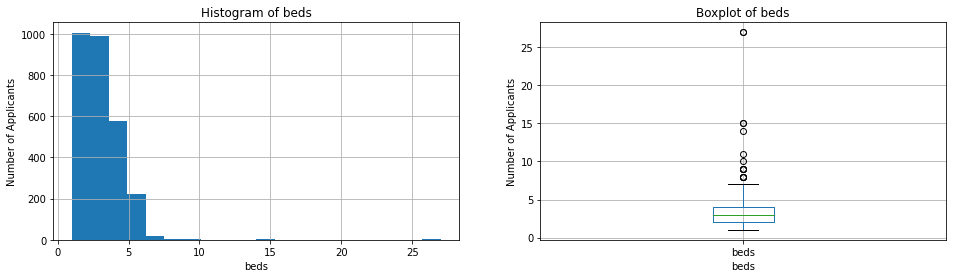

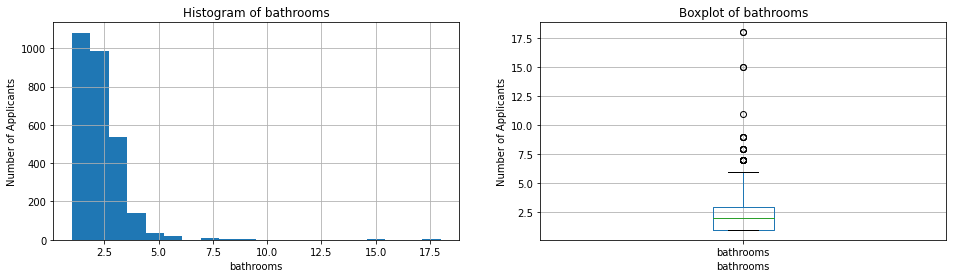

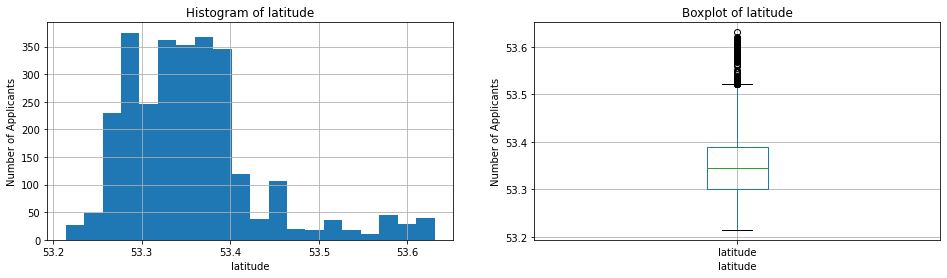

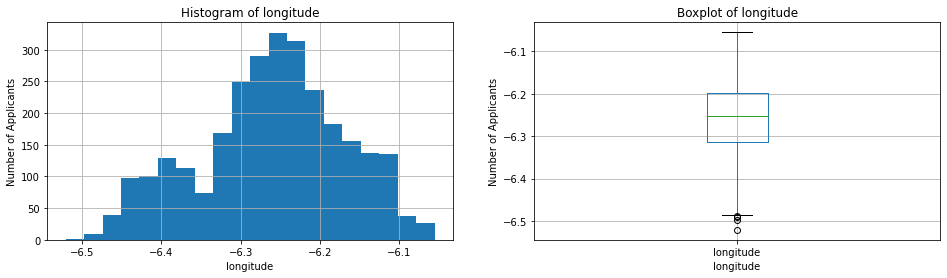

In [115]:
def plot_distribution(column_name):
    fig = plt.figure(figsize=(16,4))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Histogram of " + column_name)
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Number of Applicants')
    dftrain[column_name].hist(bins=20)

    ax3 = fig.add_subplot(1, 2, 2)
    ax3.set_title("Boxplot of " + column_name)
    ax3.set_xlabel(column_name)
    ax3.set_ylabel('Number of Applicants')
    dftrain.boxplot(column=[column_name])

    plt.show()

plot_distribution('beds')
plot_distribution('bathrooms')
plot_distribution('latitude')
plot_distribution('longitude')

# PIECEWISE REGRESSION

## Full Model

In [116]:
# Based on the above results, we select the most important features

featrain = ['beds','bathrooms','latitude', 'longitude', 'price']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['beds','bathrooms','latitude', 'longitude']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
df_subset_cost = dfcost[dfcost.index.isin(df_subset_test.index)]

print(df_subset_train.shape)
print(df_subset_test.shape)
print(df_subset_cost.shape)

(2826, 5)
(500, 4)
(500, 2)


In [117]:
#Check that all our nan values are now removed
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [118]:
#TODO: Use a robust scaler to deal with the outlier
#and also log transofrmation

In [119]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_subset_cost.Expected.values

print("Xs_train shape:", Xs_train.shape)
print("ys_train shape:", ys_train.shape)

print("Xs_test shape:", Xs_test.shape)
print("y_test shape:", y_test.shape)

Xs_train shape: (2826, 4)
ys_train shape: (2826, 1)
Xs_test shape: (500, 4)
y_test shape: (500,)


In [120]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [121]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,903.2


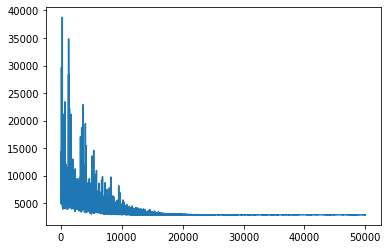

In [122]:
#Specify the number of iterations we require
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [123]:
# samples from the posterior
posterior = approximation.sample(5000)

In [124]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  212450.3340863363
MAPE =  0.2787248914054062


####PPC on the full model

In [125]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred



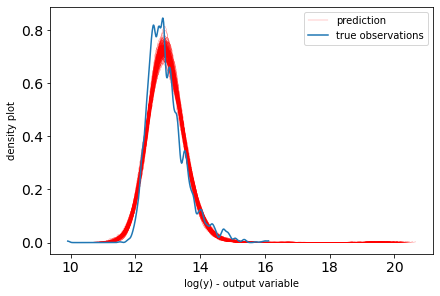

In [126]:
## Posterior predictive check (PPC) on the full model

num_samples2 = 200
Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],posterior['beta'],posterior['sigma_n'],Xn_train, nsamples=num_samples2))

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Clustering

### Full Model

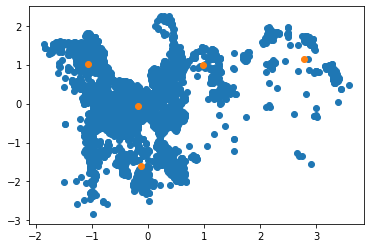

In [127]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=5)

# clustering by features latitude and longitude
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)

# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])


From the Gaussian Mixture model, it is not totally clear the optimum number of clusters, so I will also try K-Means clustering and using the elbow method to see if I can get a better idea of the number of clusters 

### Determine optimum number of clusters to use

We will use K-Means clustering to partition all our data points into k clusters. We will try for multiple different clusters, and calculate the inertia for each cluster, which is the sum of the distances of the samples to their closest cluster center. 

We are looking for an 'elbow' in the graph to determine the most appropriate k value. From the plot below, it appears 4 or 5 clusters are the optimum, I will choose 5 as an extra cluster might give a slight improvement in the model without overfitting.

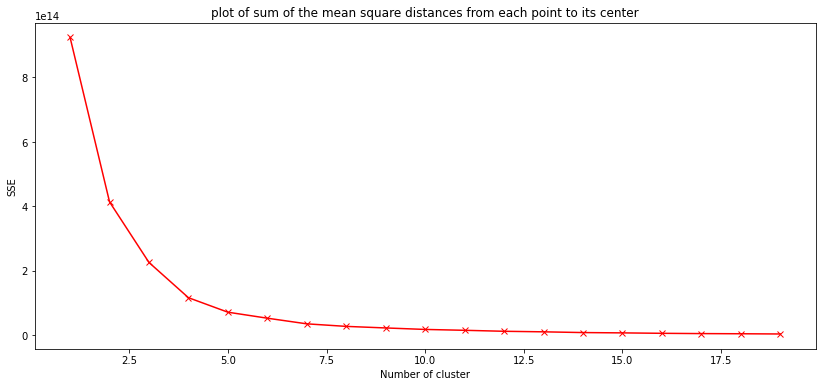

In [128]:
data = df_subset_train

sse = {}
for k in range(1, 20):
    kmeans = cluster.KMeans(init='k-means++', n_clusters=k, max_iter=300).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(14, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'rx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("plot of sum of the mean square distances from each point to its center")
plt.show()

### Clusters

In [129]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 482, 1: 1481, 2: 183, 3: 405, 4: 275}

In [130]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 61, 1: 268, 2: 41, 3: 84, 4: 46}

In [131]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [132]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [133]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)


In [134]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [135]:
# cluster 4
Xn4 = Xn_train[clusters_train==4,:]
Xtestn4 = Xn_test[clusters_test==4,:]
ylog4 = np.log(ys_train.astype('float')[clusters_train==4,:])
yscaler4 = StandardScaler().fit(ylog4)
yn4 = yscaler4.transform(ylog4)

## Piecewise Model

In [136]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 513.54


In [137]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,476.5


In [138]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 221.46


In [139]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 491.54


In [140]:
# model_4
with pm.Model() as model4:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn4.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn4.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn4[:,0])
    
with model4:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior4 = approximation.sample(5000)

Finished [100%]: Average Loss = 261.9


##Simulations

### Only Cluster 0

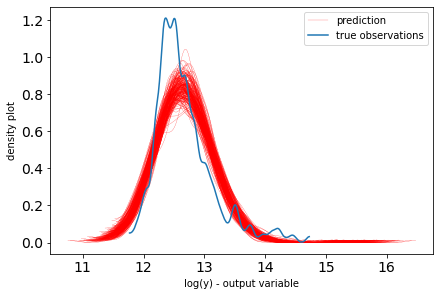

In [141]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

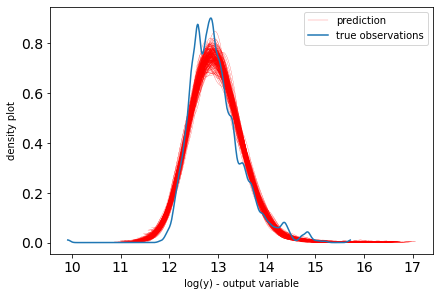

In [142]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

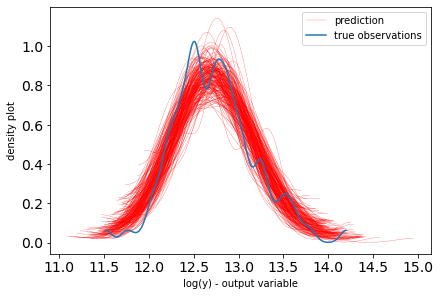

In [143]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

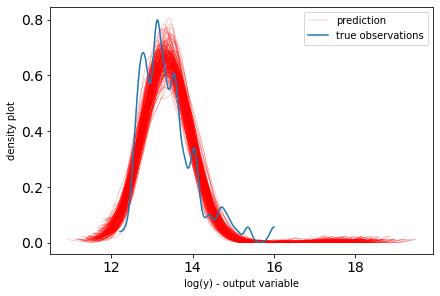

In [144]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 4


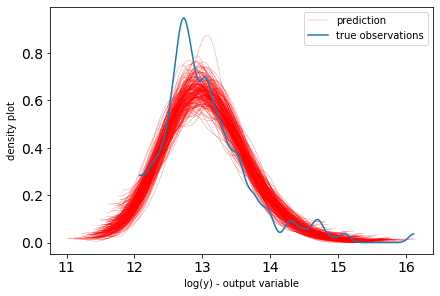

In [145]:
#Simulation
Ypred4 = yscaler4.inverse_transform(ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200))
for i in range(Ypred4.shape[0]):
    az.plot_dist( Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred4[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog4,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

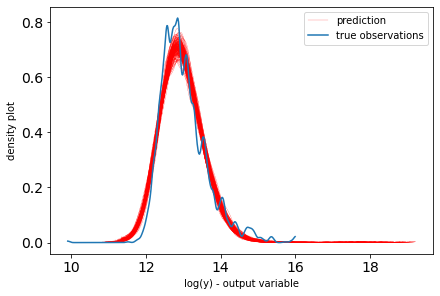

In [146]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)
Ypred4 = ppc(posterior4['alpha'],posterior4['beta'],posterior4['sigma_n'],Xn4,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [147]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))
print("MAPE = ",(np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]) /y_test[clusters_test==0])))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))
print("MAPE = ",(np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]) /y_test[clusters_test==1])))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))
print("MAPE = ",(np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]) /y_test[clusters_test==2])))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))
print("MAPE = ",(np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]) /y_test[clusters_test==3])))

# cluster 4
y_pred_BLR4 = np.exp(yscaler4.inverse_transform(np.mean(posterior4['alpha']) 
              + np.dot(np.mean(posterior4['beta'],axis=0), Xtestn4.T)))
print("Size Cluster4", np.sum(clusters_test==4), ", MAE Cluster4=",
      (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]))))
print("MAPE = ",(np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]) /y_test[clusters_test==4])))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR4 - y_test[clusters_test==4])])

joint_mape = np.mean(np.hstack([
                        abs(y_pred_BLR0 - y_test[clusters_test==0]) /y_test[clusters_test==0],
                        abs(y_pred_BLR1 - y_test[clusters_test==1]) /y_test[clusters_test==1],
                        abs(y_pred_BLR2 - y_test[clusters_test==2]) /y_test[clusters_test==2],
                        abs(y_pred_BLR3 - y_test[clusters_test==3]) /y_test[clusters_test==3],
                        abs(y_pred_BLR4 - y_test[clusters_test==4]) /y_test[clusters_test==4]
                       ]))

# MAE
print("Overall MAE=",np.mean(joint))
print("Overall MAPE = ", joint_mape)

Size Cluster0 61 , MAE Cluster0= 118297.84560550615
MAPE =  0.23218968298673132
Size Cluster1 268 , MAE Cluster1= 220276.11041688916
MAPE =  0.26509055307917756
Size Cluster2 41 , MAE Cluster2= 84016.54067312217
MAPE =  0.23197920260378407
Size Cluster3 84 , MAE Cluster3= 281728.26079766557
MAPE =  0.283956508409005
Size Cluster4 46 , MAE Cluster4= 159361.4125272527
MAPE =  0.26326924583300704
Overall MAE= 201381.28644903543
Overall MAPE =  0.2613634364176801


In [148]:
#Testing an individual point with all 4 clusters:
print(y_pred_BLR0)
y_test[clusters_test==0]
#y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
#              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0[0].T)))

[295162.01533577 329022.92178863 295629.24557154 324004.27291903
 221446.23150286 319888.77933339 270397.18014313 370039.9670784
 347215.7149024  310529.91102378 230621.87971634 569628.10373478
 301615.45899674 282301.84401625 234155.16883298 324279.69832284
 482688.46875083 245777.81503387 108558.91680261 204287.66614933
 302345.65651991 304900.00752509 245814.21183684 306942.82116763
 390669.10016036 381847.49026933 225003.47854113 303386.66311541
 669097.97751637 204287.98604388 305551.48754962 310235.84296707
 318498.65550845 228536.36430956 229112.523025   285073.08218049
 575023.19355615 347618.47476987 381601.83380844 455515.09972064
 247290.13957885 379482.3415262  288423.64397599 321173.21664182
 328175.14029363 695348.82489479 268964.75624446 268898.68464131
 424195.67612521 376518.69949817 226129.33924928 238536.2899728
 148061.68773238 355137.87376643 248786.35720401 382278.62138718
 592460.75043878 327015.65559157 480265.05457076 169258.3676329
 288560.60974136]


array([ 355000.,  425000.,  265000.,  250000.,  295000.,  550000.,
        850000.,  269000.,  340000.,  220000.,  295000., 1400000.,
        294950.,  245000.,  175000.,  540000.,  750000.,  277500.,
        550000.,  180000.,  315000.,  330000.,  340000.,  325000.,
        330000.,  270000.,  260000.,  290000., 1325000.,  140000.,
        275000.,  425000.,  290000.,  220000.,  199000.,  850000.,
        575000.,  325000.,  925000.,  360000.,  440000.,  275000.,
        345000.,  375000.,  295000.,  975000.,  245000.,  345000.,
        475000.,  435000.,  275000.,  249000.,  165000.,  335000.,
        215000.,  325000.,  470000.,  325000.,  530000.,  125000.,
        259000.])

### PPC on the Test set



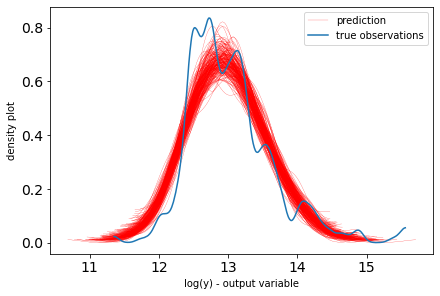

In [149]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY

##References

En.wikipedia.org. 2021. Segmented regression - Wikipedia. [online] Available at: <https://en.wikipedia.org/wiki/Segmented_regression>

Kappel, S., 2017. Piecewise regression: when one line simply isn’t enough. [online] Piecewise regression: when one line simply isn’t enough. Available at: <https://www.datadoghq.com/blog/engineering/piecewise-regression/>.

Bock, T., 2021. What are Residuals?. [online] Displayr. Available at: <https://www.displayr.com/learn-what-are-residuals/>.

Penn State, 2021. 8.8 - Piecewise Linear Regression Models | STAT 501. [online] PennState: Statistics Online Courses. Available at: <https://online.stat.psu.edu/stat501/lesson/8/8.8>.